## Importing the libraries

In [127]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Helper Functions

In [2]:
def calc_RMSE(validation_data, prediction_data):
   """
   Calculate RMSE
   """
   a = np.array(validation_data)
   b = np.array(prediction_data)

   return np.sqrt(np.mean((b-a)**2))

In [3]:
def get_fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
def make_plots(data, lags=None):
    '''
    plotting the data with specified number of lags.
    plotting raw data, then ACF and PACF
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax = raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags = lags, ax = acf)
    smt.graphics.plot_pacf(data, lags = lags, ax = pacf)
    sns.despine()
    plt.tight_layout()

In [5]:
def make_plots_2(data, lags=None):
    '''
    plotting rolling mean, rolling std and original as per number of lags
    '''
    rolling_mean = data.rolling(window = lags).mean()
    rolling_std = data.rolling(window = lags).std()
    
    original = plt.plot(data, color='black',label = 'Original Timeseries')
    mean = plt.plot(rolling_mean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original, Rolling Mean, Standard Deviation')
    sns.despine()
    plt.show()

In [6]:
def split_train_test_chronological(df, ratio = 0.9):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    '''
    
    size = len(df) * ratio
    size_round = round(size)
    
    df_train = df[0:(size_round)]
    df_test = df[size_round:]
    
    return df_train, df_test

## Importing data

In [7]:
df_bitcoin_price = pd.read_pickle('../crypto_currency_and_market_value_history/data/bitcoin_4_year_hourly_history_df.pickle')

In [8]:
df_bitcoin_price.head(3)

,timestamp,open,high,low,close,volume (btc),volume (currency),weighted price
0,2015-05-31 00:00:00,232.11,232.11,231.92,231.92,223.37,51822.18,232.00
1,2015-05-31 01:00:00,231.88,232.32,231.87,232.32,217.49,50452.68,231.98
2,2015-05-31 02:00:00,231.97,232.51,231.88,232.51,46.45,10782.23,232.14


In [9]:
df_vix = pd.read_pickle('../crypto_currency_and_market_value_history/data/vix_volatility_daily_change_history_df.pickle')

In [10]:
df_vix.head(3)

,trade date,open,high,low,close,settle,change,total volume
0,2019-06-07,-0.014837,-0.019264,-0.006116,0.006591,0.015175,-2.666667,-0.066600
1,2019-06-06,-0.023754,-0.021143,-0.015060,0.002402,-0.009023,-0.750000,-0.038795
2,2019-06-05,-0.054247,-0.047360,-0.034884,-0.032539,-0.034833,-0.428571,-0.149433


In [11]:
df_gold = pd.read_csv('../crypto_currency_and_market_value_history/data/gold_hourly_data.csv', sep = ';')

In [12]:
df_gold.head(3)

,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
0,01/08/2017 0:00,0.097156,1027.0,148.0,403.0,476.0,-0.504061,0.432704,2855.81,2863.06,2823.00,2825.92,184.02,"522951,00"
1,01/08/2017 1:00,0.064507,778.0,143.0,239.0,396.0,-0.381007,0.437953,2823.01,2860.02,2821.01,2853.38,77.3,219605.16
2,01/08/2017 2:00,0.119218,836.0,118.0,333.0,385.0,-0.394999,0.439269,2846.27,2858.04,2837.31,2841.60,135.83,386739.15


## Preprocessing

In [13]:
df_vix = df_vix.sort_values(by=['trade date']).reset_index()

In [14]:
df_vix.head(3)

,index,trade date,open,high,low,close,settle,change,total volume
0,3509,2005-06-21,0.004720,0.004720,0.004720,0.004720,0.005394,-0.994606,NaN
1,3508,2005-06-22,-0.004027,-0.004027,-0.004027,-0.004027,-0.003353,-1.625000,-0.8
2,3507,2005-06-23,0.009434,0.014151,0.004717,0.014151,0.017497,-6.200000,5.1


In [15]:
df_vix.drop(['index'], axis = 1, inplace = True)

In [16]:
df_vix.tail(3)

,trade date,open,high,low,close,settle,change,total volume
3507,2019-06-05,-0.054247,-0.047360,-0.034884,-0.032539,-0.034833,-0.428571,-0.149433
3508,2019-06-06,-0.023754,-0.021143,-0.015060,0.002402,-0.009023,-0.750000,-0.038795
3509,2019-06-07,-0.014837,-0.019264,-0.006116,0.006591,0.015175,-2.666667,-0.066600


## Processing for FB Prophet

In [17]:
df_vix_FBP = df_vix.copy()

In [18]:
df_bitcoin_price_FBP = df_bitcoin_price.copy()

In [19]:
df_bitcoin_price_FBP.rename(columns={'timestamp': 'ds', 'weighted price': 'y'}, inplace=True)

In [20]:
df_bitcoin_price_FBP = df_bitcoin_price_FBP[['ds', 'y']]

In [21]:
df_bitcoin_price_FBP.tail()

,ds,y
35232,2019-06-09 16:00:00,7664.22
35233,2019-06-09 17:00:00,7645.34
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


### Train Test Validation split using helper function

In [118]:
df_train, df_test = split_train_test_chronological(df_bitcoin_price_FBP, 0.98)

In [119]:
df_train, df_val = split_train_test_chronological(df_train.reset_index(), 0.98)

In [120]:
df_train.head(3)

,index,ds,y
0,0,2015-05-31 00:00:00,232.00
1,1,2015-05-31 01:00:00,231.98
2,2,2015-05-31 02:00:00,232.14


In [121]:
df_train.tail(3)

,index,ds,y
33838,33838,2019-04-12 14:00:00,5073.44
33839,33839,2019-04-12 15:00:00,5074.59
33840,33840,2019-04-12 16:00:00,5079.88


In [122]:
df_val.head(3)

,index,ds,y
33841,33841,2019-04-12 17:00:00,5086.64
33842,33842,2019-04-12 18:00:00,5068.26
33843,33843,2019-04-12 19:00:00,5068.03


In [123]:
df_val.tail(3)

,index,ds,y
34529,34529,2019-05-11 09:00:00,6758.52
34530,34530,2019-05-11 10:00:00,6820.41
34531,34531,2019-05-11 11:00:00,6807.65


In [124]:
df_test.head(3)

,ds,y
34532,2019-05-11 12:00:00,6764.24
34533,2019-05-11 13:00:00,6802.68
34534,2019-05-11 14:00:00,6789.77


In [125]:
df_test.tail(3)

,ds,y
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


In [126]:
df_bitcoin_price_FBP.tail(3)

,ds,y
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


## FB Prophet Baseline

In [113]:
proph = Prophet()

In [114]:
proph.fit(df_train)

In [115]:
forecast = proph.predict(df_val)

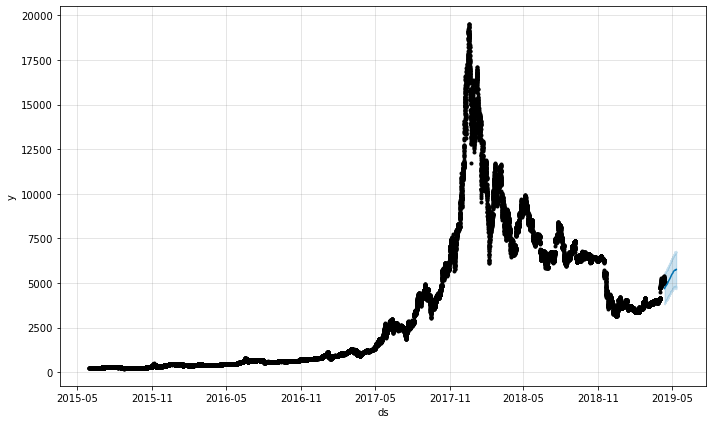

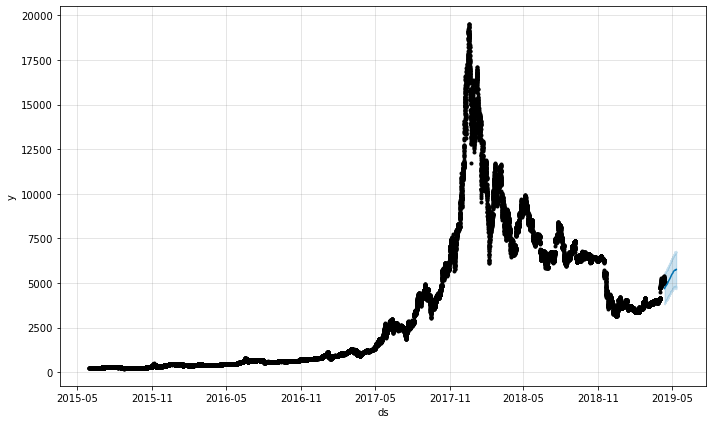

In [116]:
proph.plot(forecast)

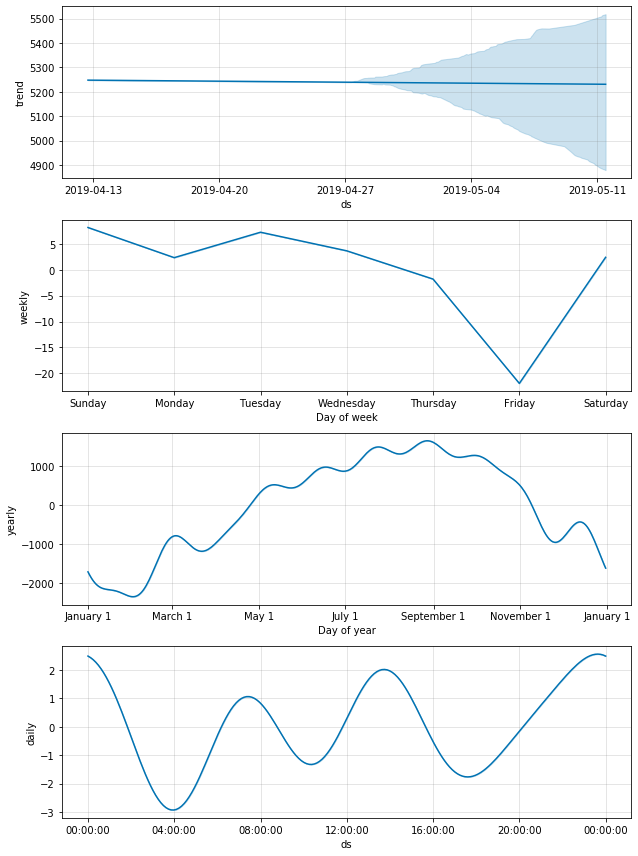

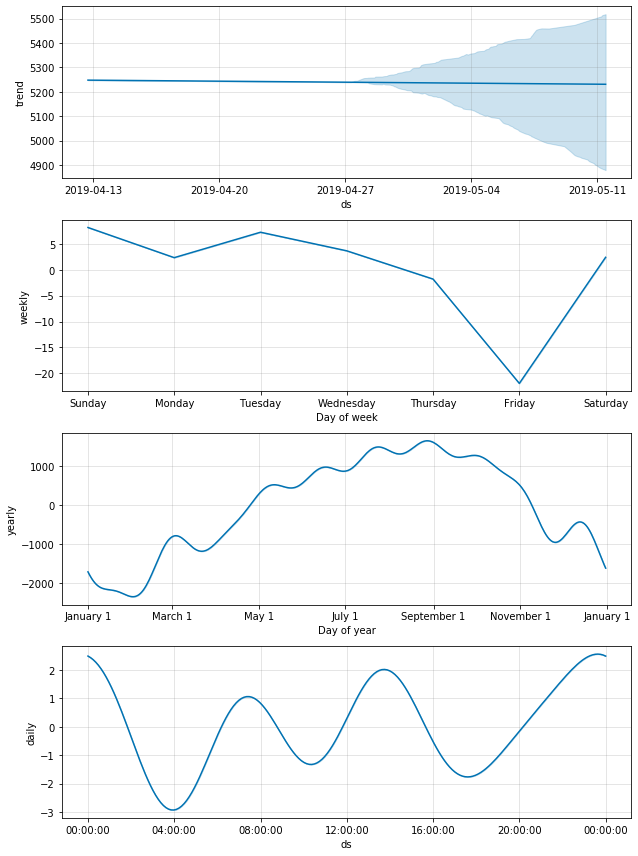

In [117]:
proph.plot_components(forecast)

## Baseline ARIMA model

### Window refitting model

The make_window_refitting_ARIMA_model is taking a really long time to train, as it is retraining for every new observation.

In [216]:
def make_window_refitting_ARIMA_model(df_t = df_train['y'] , df_v = df_val['y'],p = 1, d = 1, q = 0):
    preds = []
    df_t = list(df_t)

    for i in df_v:
        model = ARIMA(df_t, order=(p,d,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df_t.append(i)

    plt.plot(df_v)
    plt.plot(preds)
    rmse = calc_RMSE(validation,np.array(preds))
    print(rmse)
    
    return rmse,df_v,preds,model

In [34]:
# res = make_window_refitting_model(df_t = df_train['y'], p = 1, d = 0 , q = 1)

In [220]:
model = ARIMA(df_train.y, order=(1,0,1)).fit()

In [ ]:
df_val;

## Baseline LSTM Model

In [135]:
# date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_train.columns[1:]]),
#                           data=[i for i in range(len(df_train.columns[1:]))])

# series_array = df_train[df_train.columns[1:]].values

In [136]:
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

In [137]:
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

In [138]:
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array